Execução: 36 | Score atual: 0.9433 | Melhor geral: 0.9858


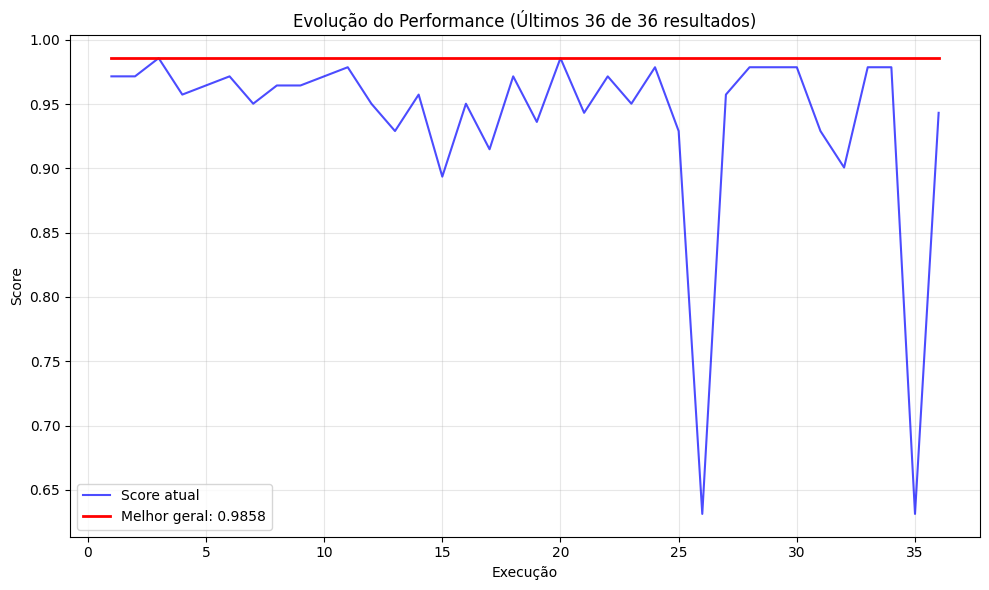

Monitoramento interrompido pelo usuário


In [3]:
import json, pandas as pd, pathlib, itertools, time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import deque

log = pathlib.Path("autoskl_runs.jsonl")

def stream():
    # Verifica se o arquivo existe
    if not log.exists():
        print(f"Arquivo {log} não encontrado!")
        return
    
    with log.open() as f:
        # Primeiro, lê dados existentes
        f.seek(0)
        for linha in f:
            if linha.strip():
                try:
                    yield json.loads(linha)
                except json.JSONDecodeError:
                    continue
        
        # Depois monitora novas entradas
        while True:
            linha = f.readline()
            if linha:
                try:
                    yield json.loads(linha)
                except json.JSONDecodeError:
                    continue
            else:
                time.sleep(0.5)

# Verificar se arquivo existe antes de começar
if not log.exists():
    print(f"Criando arquivo de exemplo: {log}")
    # Criar dados de exemplo para teste
    with log.open('w') as f:
        for i in range(5):
            f.write(json.dumps({"score": 0.5 + i * 0.1}) + "\n")
            f.flush()

# Configurar limite de resultados para visualização
LIMITE_RESULTADOS = 50

melhor_geral = float('-inf')  # Melhor score geral (mantido sempre)
scores = deque(maxlen=LIMITE_RESULTADOS)  # Últimos 50 scores
timestamps = deque(maxlen=LIMITE_RESULTADOS)  # Últimos 50 timestamps
contador = 0

# Configurar matplotlib para Jupyter
%matplotlib inline
plt.ion()

try:
    for evento in stream():
        if "score" not in evento:
            continue
        
        # Ignora eventos com status diferente de SUCCESS
        if evento.get("status") != "SUCCESS":
            continue
            
        contador += 1
        score_atual = evento["score"]
        
        # Atualiza melhor geral (NUNCA é resetado)
        melhor_geral = max(melhor_geral, score_atual)
        
        # Adiciona aos deques (remove automaticamente o mais antigo se passar do limite)
        scores.append(score_atual)
        timestamps.append(contador)
        
        # Cria lista com melhor geral repetido para cada ponto da janela
        melhores_geral = [melhor_geral] * len(scores)
        
        # Limpa saída anterior
        clear_output(wait=True)
        
        # Cria novo gráfico
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(list(timestamps), list(scores), 'b-', alpha=0.7, label='Score atual')
        ax.plot(list(timestamps), melhores_geral, 'r-', linewidth=2, label=f'Melhor geral: {melhor_geral:.4f}')
        ax.set_xlabel('Execução')
        ax.set_ylabel('Score')
        ax.set_title(f'Evolução do Performance (Últimos {len(scores)} de {contador} resultados)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # Mostra informações
        print(f"Execução: {contador} | Score atual: {score_atual:.4f} | Melhor geral: {melhor_geral:.4f}")
        
        # Mostra o gráfico
        display(fig)
        plt.close(fig)
        
        time.sleep(0.1)
        
except KeyboardInterrupt:
    print("Monitoramento interrompido pelo usuário")
except Exception as e:
    print(f"Erro: {e}")
finally:
    plt.ioff()